<a href="https://colab.research.google.com/github/balnarendrasapa/road-detection/blob/master/submissions/Update%202/Update_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the Repository

[Repository Link](https://github.com/balnarendrasapa/road-detection)

- This is our team's repository. This repository contains all the necessary code that we worked on and it also contains the dataset that we annotated.

- You do not need to do anything like uploading and adjusting the paths. Just run the cells sequentially.

- All the necessary commands are written in this notebook itself

In [1]:
!git clone https://github.com/balnarendrasapa/road-detection.git

Cloning into 'road-detection'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 421 (delta 59), reused 39 (delta 15), pack-reused 259
Receiving objects: 100% (421/421), 203.36 MiB | 36.05 MiB/s, done.
Resolving deltas: 100% (152/152), done.


## Install the Requirements

- Install all the python dependencies
- After Installing dependencies, Restart the runtime. If you do not restart the runtime, the python will throw "module not found error"

In [2]:
!pip install -r road-detection/TwinLiteNet/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.4 MB/s

## Copy Dataset from Repository

- Our repository contains dataset.zip in datasets folder in the repository. copy that zip file to root

In [1]:
!cp road-detection/datasets/dataset.zip ./

## Unzip the file

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/road_image_160.png  
  inflating: dataset/test/images/road_image_161.png  
  inflating: dataset/test/images/road_image_162.png  
  inflating: dataset/test/images/road_image_163.png  
  inflating: dataset/test/images/road_image_164.png  
  inflating: dataset/test/images/road_image_165.png  
  inflating: dataset/test/images/road_image_166.png  
  inflating: dataset/test/images/road_image_167.png  
  inflating: dataset/test/images/road_image_168.png  
  inflating: dataset/test/images/road_image_169.png  
  inflating: dataset/test/images/road_image_170.png  
  inflating: dataset/test/images/road_image_171.png  
  inflating: dataset/test/images/road_image_172.png  
  inflating: dataset/test/images/road_image_173.png  
  inflating: dataset/test/images/road_image_174.png  
  inflating: dataset/test/images/road_image_175.png  
  inflating: dataset/test/images/road_image_176.png  

## Import the all the required libraries

In [1]:
import torch
import cv2
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import os
import random
import math
from matplotlib import pyplot as plt
import torch.nn as nn

## Image transformation functions

- By paper author

In [2]:
def augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """change color hue, saturation, value"""
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [3]:
def random_perspective(combination,  degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    """combination of img transform"""
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]
    img, gray, line = combination
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpPerspective(gray, M, dsize=(width, height), borderValue=0)
            line = cv2.warpPerspective(line, M, dsize=(width, height), borderValue=0)
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpAffine(gray, M[:2], dsize=(width, height), borderValue=0)
            line = cv2.warpAffine(line, M[:2], dsize=(width, height), borderValue=0)



    combination = (img, gray, line)
    return combination

## Custom Dataset Class

- This custom dataset class is based on the dataset class written by the author but with slight modifications like path. we have adjusted the path according to the google colab.

In [4]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, transform=None, valid=False, test=False):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        :param transform: Type of transformation. SEe Transforms.py for supported transformations
        '''

        self.transform = transform
        self.Tensor = transforms.ToTensor()
        self.valid=valid
        if valid:
            self.root='dataset/validation/images'
            self.names=os.listdir(self.root)
        elif test:
            self.root='dataset/test/images'
            self.names=os.listdir(self.root)
        else:
            self.root='dataset/train/images/'
            self.names=os.listdir(self.root)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        W_=640
        H_=360
        image_name=os.path.join(self.root,self.names[idx])

        image = cv2.imread(image_name)
        original_image = cv2.imread(image_name)
        label1 = cv2.imread(image_name.replace("images","segments").replace("jpg","png"), 0)
        label2 = cv2.imread(image_name.replace("images","lane").replace("jpg","png"), 0)
        if not self.valid:
            if random.random()<0.5:
                combination = (image, label1, label2)
                (image, label1, label2)= random_perspective(
                    combination=combination,
                    degrees=10,
                    translate=0.1,
                    scale=0.25,
                    shear=0.0
                )
            if random.random()<0.5:
                augment_hsv(image)
            if random.random() < 0.5:
                image = np.fliplr(image)
                label1 = np.fliplr(label1)
                label2 = np.fliplr(label2)

        label1 = cv2.resize(label1, (W_, H_))
        label2 = cv2.resize(label2, (W_, H_))
        image = cv2.resize(image, (W_, H_))

        _,seg_b1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY_INV)
        _,seg_b2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY_INV)
        _,seg1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY)
        _,seg2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY)

        seg1 = self.Tensor(seg1)
        seg2 = self.Tensor(seg2)
        seg_b1 = self.Tensor(seg_b1)
        seg_b2 = self.Tensor(seg_b2)
        seg_da = torch.stack((seg_b1[0], seg1[0]),0)
        seg_ll = torch.stack((seg_b2[0], seg2[0]),0)
        image = image[:, :, ::-1].transpose(2, 0, 1)
        image = np.ascontiguousarray(image)

        return original_image, image_name,torch.from_numpy(image),(seg_da,seg_ll)

## Intialize a dataloader

- Intialize a dataloader with batch size 8

- Intialize train, test, validation datasets.

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyDataset(), batch_size = 8, shuffle = True)
test_dataloader = DataLoader(MyDataset(test=True), batch_size = 8, shuffle = True)
val_dataloader = DataLoader(MyDataset(valid=True), batch_size = 8, shuffle = True)

## Display images

- Show first sample of each mini-batch with size 8

dataset/train/images/road_image_137.png
dataset/train/images/road_image_129.png
dataset/train/images/road_image_95.png
dataset/train/images/road_image_37.png
dataset/train/images/road_image_102.png
dataset/train/images/road_image_48.png
dataset/train/images/road_image_78.png
dataset/train/images/road_image_81.png
dataset/train/images/road_image_124.png
dataset/train/images/road_image_135.png
dataset/train/images/road_image_29.png
dataset/train/images/road_image_25.png
dataset/train/images/road_image_19.png
dataset/train/images/road_image_122.png
dataset/train/images/road_image_86.png
dataset/train/images/road_image_114.png
dataset/train/images/road_image_153.png
dataset/train/images/road_image_116.png
dataset/train/images/road_image_17.png
dataset/train/images/road_image_149.png


<Figure size 10000x10000 with 0 Axes>

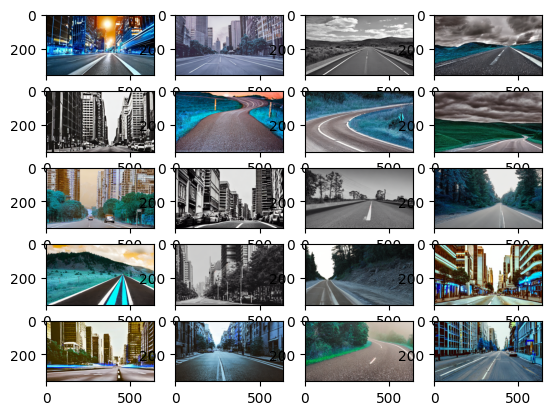

In [6]:
# Printing the first sample of the each minibatch of size 8

plt.figure(figsize = (100, 100))

f, axarr = plt.subplots(5, 4)
i = 0
j = 0

for batch in train_dataloader:
  original_image, image_name, input, target = batch
  print(image_name[0])
  axarr[i, j].imshow(original_image[0])
  j += 1
  if j%4 == 0:
    i += 1
    j = 0

plt.show()

## Copy the required files from the repository to Root

In [12]:
# Copy pretrained model from repository to root
!cp road-detection/TwinLiteNet/pretrained/best.pth ./

# Copy pytorch Neural Net from repo to root
!cp road-detection/TwinLiteNet/model/TwinLite.py ./

# Copy Loss function pytorch code from repo to root
!cp road-detection/TwinLiteNet/loss.py ./

# Copy all reqired constants from repo to root
!cp road-detection/TwinLiteNet/const.py ./

## Load the pretrained model

In [7]:
import TwinLite as net


model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('best.pth'))


<All keys matched successfully>

## Intialize loss and optimizer.

- This is based on the original code from paper author

In [8]:
from tqdm import tqdm
from loss import TotalLoss

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

criteria = TotalLoss()

In [9]:
args = dict()

args["lr"] = lr
args["max_epochs"] = 8
args["onGPU"] = True

In [10]:
args

{'lr': 0.0005, 'max_epochs': 8, 'onGPU': True}

## Intialize Polynomial Learning Rate Scheduler

- By Paper Author

In [11]:
def poly_lr_scheduler(args, optimizer, epoch, power=2):
    lr = round(args["lr"] * (1 - epoch / args["max_epochs"]) ** power, 8)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

## Write a trainer function for each epoch

- By Paper Author

In [12]:
def train(args, train_loader, model, criterion, optimizer, epoch):
    model.train()

    total_batches = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(pbar, total=total_batches, bar_format='{l_bar}{bar:10}{r_bar}')
    j = 0
    avg_train_loss = 0
    for i, (_, _, input, target) in pbar:
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)

        # target=target.cuda()
        optimizer.zero_grad()

        focal_loss,tversky_loss,loss = criterion(output,target)
        avg_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(('%13s' * 1 + '%13.4g' * 3) %
                                     (f'{epoch}/{args["max_epochs"] - 1}', tversky_loss, focal_loss, loss.item()))
        j += 1
    return avg_train_loss/j, loss.item()

## Train the model with custom data and also print the loss

- This loss is based on the paper

In [13]:
print("------------------------------------------")

for epoch in range(0, args["max_epochs"]):
    print(f"Epoch: {epoch + 1}/{args['max_epochs']}")
    poly_lr_scheduler(args, optimizer, epoch)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Learning rate: " +  str(lr))
    print()

    # train for one epoch
    model.train()
    avg_train_loss, loss_for_last_batch_train = train( args, train_dataloader, model, criteria, optimizer, epoch)
    model.eval()

    avg_val_loss = 0
    i = 0
    for batch in val_dataloader:
        _, _, input, target = batch
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)
        focal_loss, tversky_loss, loss = criteria(output, target)
        avg_val_loss += loss.item()
        i += 1

    print()
    print(f"Average Training Loss: {avg_train_loss}")
    print(f"Average Validation Loss: {avg_val_loss/i}")
    print()
    print(f"Training loss for last batch: {loss_for_last_batch_train}")
    print(f"Validation loss for last batch: {loss.item()}")
    print("------------------------------------------")


------------------------------------------
Epoch: 1/8
Learning rate: 0.0005



          0/7       0.1095      0.06467       0.1742: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



Average Training Loss: 0.3576262012124062
Average Validation Loss: 0.2728695770104726

Training loss for last batch: 0.1741946041584015
Validation loss for last batch: 0.2839277982711792
------------------------------------------
Epoch: 2/8
Learning rate: 0.00038281



          1/7       0.1662       0.0565       0.2227: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]



Average Training Loss: 0.25929028242826463
Average Validation Loss: 0.2384017656246821

Training loss for last batch: 0.22266727685928345
Validation loss for last batch: 0.1855241060256958
------------------------------------------
Epoch: 3/8
Learning rate: 0.00028125



          2/7       0.2878       0.3491       0.6369: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]



Average Training Loss: 0.24382387697696686
Average Validation Loss: 0.26573528349399567

Training loss for last batch: 0.6368532776832581
Validation loss for last batch: 0.2246667891740799
------------------------------------------
Epoch: 4/8
Learning rate: 0.00019531



          3/7       0.2402       0.1314       0.3717: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]



Average Training Loss: 0.20304674580693244
Average Validation Loss: 0.22440774738788605

Training loss for last batch: 0.371662974357605
Validation loss for last batch: 0.17283737659454346
------------------------------------------
Epoch: 5/8
Learning rate: 0.000125



          4/7        0.111      0.04476       0.1558: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]



Average Training Loss: 0.18554734326899053
Average Validation Loss: 0.2292183389266332

Training loss for last batch: 0.15575626492500305
Validation loss for last batch: 0.31317853927612305
------------------------------------------
Epoch: 6/8
Learning rate: 7.031e-05



          5/7       0.1284      0.09481       0.2232: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]



Average Training Loss: 0.16506880819797515
Average Validation Loss: 0.1946761061747869

Training loss for last batch: 0.22317996621131897
Validation loss for last batch: 0.19669288396835327
------------------------------------------
Epoch: 7/8
Learning rate: 3.125e-05



          6/7      0.06761      0.03078      0.09838: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]



Average Training Loss: 0.1671056818217039
Average Validation Loss: 0.22296717266241708

Training loss for last batch: 0.09838452935218811
Validation loss for last batch: 0.34202462434768677
------------------------------------------
Epoch: 8/8
Learning rate: 7.81e-06



          7/7       0.1168      0.05917        0.176: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]



Average Training Loss: 0.14991373680531977
Average Validation Loss: 0.17914162079493204

Training loss for last batch: 0.17601341009140015
Validation loss for last batch: 0.1380920708179474
------------------------------------------


## Evaluating the model on Test data

In [14]:
avg_test_loss = 0
i = 0
for batch in test_dataloader:
    _, _, input, target = batch
    if args["onGPU"] == True:
        input = input.cuda().float() / 255.0
    output = model(input)
    focal_loss, tversky_loss, loss = criteria(output, target)
    avg_test_loss += loss.item()
    i += 1

print("------------------------------------------")
print(f"Average Testing Loss: {avg_test_loss/i}")
print(f"Testing loss for last batch: {loss.item()}")
print("------------------------------------------")

------------------------------------------
Average Testing Loss: 0.22360451519489288
Testing loss for last batch: 0.19261185824871063
------------------------------------------
